<a href="https://colab.research.google.com/github/RobMulla/2nd_place_GISLR/blob/main/colab/asl_fingerspelling_colab_v43.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cutmix Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q --upgrade pip
# !pip install -q /kaggle/input/tensorflow-2120/tensorflow-2.12.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q tensorflow-addons==0.20.0
!pip install -q git+https://github.com/hoyso48/tf-utils@main
!pip install -q wandb
!pip install -q cached-property
# !pip install -q fastparquet
!pip install -q Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 31.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
flax 0.7.0 requires jax>=0.4.2, but you have jax 0.3.25 which is incompatible.
orbax-checkpoint 0.3.1 requires jax>=0.4.9, but you have jax 0.3.25 which is incompatible.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [ ]:
!gsutil cp gs://kds-d252915ee60b8c4563394c70daacaafcdb7b9caf37cd7e73e4942002/train.csv .
!gsutil cp gs://kds-d252915ee60b8c4563394c70daacaafcdb7b9caf37cd7e73e4942002/character_to_prediction_index.json .
!gsutil cp gs://kds-d252915ee60b8c4563394c70daacaafcdb7b9caf37cd7e73e4942002/supplemental_metadata.csv .

!gsutil cp gs://kds-a7411ffc5567ec72c45d9f2d0f511703f0869b183ac244063f25b061/CTC_TPU.py .

Copying gs://kds-d252915ee60b8c4563394c70daacaafcdb7b9caf37cd7e73e4942002/train.csv...
- [1 files][  5.0 MiB/  5.0 MiB]                                                
Operation completed over 1 objects/5.0 MiB.                                      
Copying gs://kds-d252915ee60b8c4563394c70daacaafcdb7b9caf37cd7e73e4942002/character_to_prediction_index.json...
/ [1 files][  405.0 B/  405.0 B]                                                
Operation completed over 1 objects/405.0 B.                                      
Copying gs://kds-d252915ee60b8c4563394c70daacaafcdb7b9caf37cd7e73e4942002/supplemental_metadata.csv...
/ [1 files][  4.8 MiB/  4.8 MiB]                                                
Operation completed over 1 objects/4.8 MiB.                                      
Copying gs://kds-a7411ffc5567ec72c45d9f2d0f511703f0869b183ac244063f25b061/CTC_TPU.py...
/ [1 files][ 56.1 KiB/ 56.1 KiB]                                                
Operation completed over 1 objects/56.1 

In [ ]:
import gc
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from cached_property import cached_property

import tensorflow.keras.mixed_precision as mixed_precision
import os

import random
import sys
import Levenshtein as lev

from wandb.keras import WandbMetricsLogger
import wandb
import matplotlib.pyplot as plt

from tf_utils.schedules import OneCycleLR, ListedLR
from tf_utils.callbacks import Snapshot, SWA
from tf_utils.learners import FGM, AWP

print(f"Tensorflow Version: {tf.__version__}")
print(f"Python Version: {sys.version}")

GS_FINGERSPELLING = "gs://kds-d252915ee60b8c4563394c70daacaafcdb7b9caf37cd7e73e4942002"
# GS_TFREC = "gs://kds-dae29c7a0821eade58ed9a7bce96cf269a941a9f53705eef682a744b"
GS_TFREC = "gs://kds-4223cf837e824b2c10d7ee219958cd6fefa27d65a4750dd2b589ed40"  # New version with frame labels
GS_SUPP = "gs://kds-f650b0f8ab8ed6c10c78187b75023a622514dd9440bc168c6fd88fd5"
GS_CTC = "gs://kds-a7411ffc5567ec72c45d9f2d0f511703f0869b183ac244063f25b061"

# import all our functions
from CTC_TPU import classic_ctc_loss

# Seed all random number generators
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


def get_strategy(device="TPU-VM"):
    IS_TPU = False
    if "TPU" in device:
        tpu = "local" if device == "TPU-VM" else None
        print("connecting to TPU...")
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        IS_TPU = True

    if device == "GPU" or device == "CPU":
        ngpu = len(tf.config.experimental.list_physical_devices("GPU"))
        if ngpu > 1:
            print("Using multi GPU")
            strategy = tf.distribute.MirroredStrategy()
        elif ngpu == 1:
            print("Using single GPU")
            strategy = tf.distribute.get_strategy()
        else:
            print("Using CPU")
            strategy = tf.distribute.get_strategy()
            cfg["device"] = "CPU"

    if device == "GPU":
        print("Num GPUs Available: ", ngpu)

    AUTO = tf.data.experimental.AUTOTUNE
    REPLICAS = strategy.num_replicas_in_sync
    print(f"REPLICAS: {REPLICAS}")

    return strategy, REPLICAS, IS_TPU

STRATEGY, N_REPLICAS, IS_TPU = get_strategy("TPU")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Tensorflow Version: 2.12.0
Python Version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
connecting to TPU...
REPLICAS: 8


In [ ]:
TRAIN_FILENAMES = tf.io.gfile.glob(GS_TFREC + "/*")
SUPP_FILENAMES = tf.io.gfile.glob(GS_SUPP + "/*")

train_df = pd.read_csv("train.csv")
sup_df = pd.read_csv('supplemental_metadata.csv')

def count_data_items(filenames):
    fnums = [int(filename.split("/")[-1].split(".")[0]) for filename in filenames]
    return train_df.loc[train_df["file_id"].isin(fnums)].shape[0]


print("Number for training files", len(TRAIN_FILENAMES))
print("Number for supp files", len(SUPP_FILENAMES))
print("Number of data items", count_data_items(TRAIN_FILENAMES), len(train_df))
assert count_data_items(TRAIN_FILENAMES) == len(train_df)

# fmt:off
ROWS_PER_FRAME = 543
MAX_LEN = 384
CROP_LEN = MAX_LEN
NUM_CLASSES = 60
PAD = -100.
NOSE = [1, 2, 98, 327]
LNOSE = [98]
RNOSE = [327]
LIP = [0, 61, 185, 40, 39, 37, 267, 269, 270, 409,
       291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
       78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
       95, 88, 178, 87, 14, 317, 402, 318, 324, 308, ]
LLIP = [84, 181, 91, 146, 61, 185, 40,
        39, 37, 87, 178, 88, 95, 78, 191, 80,
        81, 82]
RLIP = [314, 405, 321, 375, 291, 409,
        270, 269, 267, 317, 402, 318,
        324, 308, 415, 310, 311, 312]

POSE = [500, 502, 504, 501, 503, 505, 512, 513]
LPOSE = [513, 505, 503, 501]
RPOSE = [512, 504, 502, 500]

REYE = [
    33, 7, 163, 144, 145, 153, 154, 155, 133,
    246, 161, 160, 159, 158, 157, 173,
]
LEYE = [
    263, 249, 390, 373, 374, 380, 381, 382, 362,
    466, 388, 387, 386, 385, 384, 398,
]

LHAND = np.arange(468, 489).tolist()
RHAND = np.arange(522, 543).tolist()
MAX_PHRASE_LENGTH = 64

# fmt: on

POINT_LANDMARKS = LIP + LHAND + RHAND # + NOSE + REYE + LEYE  # +POSE

NUM_NODES = len(POINT_LANDMARKS)
CHANNELS = 6 * NUM_NODES

print('Number of nodes', NUM_NODES)
print('Number of channels', CHANNELS)

with open("character_to_prediction_index.json", "r",) as f:
    char_to_num = json.load(f)
pad_token = "^"
pad_token_idx = 59
char_to_num[pad_token] = pad_token_idx
num_to_char = {j: i for i, j in char_to_num.items()}

Number for training files 68
Number for supp files 53
Number of data items 67208 67208
Number of nodes 82
Number of channels 492


In [ ]:
def interp1d_(x, target_len, method="random"):
    length = tf.shape(x)[1]
    target_len = tf.maximum(1, target_len)
    if method == "random":
        if tf.random.uniform(()) < 0.33:
            x = tf.image.resize(x, (target_len, tf.shape(x)[1]), "bilinear")
        else:
            if tf.random.uniform(()) < 0.5:
                x = tf.image.resize(x, (target_len, tf.shape(x)[1]), "bicubic")
            else:
                x = tf.image.resize(x, (target_len, tf.shape(x)[1]), "nearest")
    else:
        x = tf.image.resize(x, (target_len, tf.shape(x)[1]), method)
    return x


def tf_nan_mean(x, axis=0, keepdims=False):
    return tf.reduce_sum(
        tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis, keepdims=keepdims
    ) / tf.reduce_sum(
        tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)),
        axis=axis,
        keepdims=keepdims,
    )


def tf_nan_std(x, center=None, axis=0, keepdims=False):
    if center is None:
        center = tf_nan_mean(x, axis=axis, keepdims=True)
    d = x - center
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis, keepdims=keepdims))


class Preprocess(tf.keras.layers.Layer):
    def __init__(self, max_len=MAX_LEN, point_landmarks=POINT_LANDMARKS, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.point_landmarks = point_landmarks

    def call(self, inputs):
        if tf.rank(inputs) == 3:
            x = inputs[None, ...]
        else:
            x = inputs

        mean = tf_nan_mean(tf.gather(x, [17], axis=2), axis=[1, 2], keepdims=True)
        mean = tf.where(tf.math.is_nan(mean), tf.constant(0.5, x.dtype), mean)
        x = tf.gather(x, self.point_landmarks, axis=2)  # N,T,P,C
        std = tf_nan_std(x, center=mean, axis=[1, 2], keepdims=True)

        x = (x - mean) / std

        if self.max_len is not None:
            x = x[:, : self.max_len]
        length = tf.shape(x)[1]
        x = x[..., :2]

        dx = tf.cond(
            tf.shape(x)[1] > 1,
            lambda: tf.pad(x[:, 1:] - x[:, :-1], [[0, 0], [0, 1], [0, 0], [0, 0]]),
            lambda: tf.zeros_like(x),
        )

        dx2 = tf.cond(
            tf.shape(x)[1] > 2,
            lambda: tf.pad(x[:, 2:] - x[:, :-2], [[0, 0], [0, 2], [0, 0], [0, 0]]),
            lambda: tf.zeros_like(x),
        )

        x = tf.concat(
            [
                tf.reshape(x, (-1, length, 2 * len(self.point_landmarks))),
                tf.reshape(dx, (-1, length, 2 * len(self.point_landmarks))),
                tf.reshape(dx2, (-1, length, 2 * len(self.point_landmarks))),
            ],
            axis=-1,
        )

        x = tf.where(tf.math.is_nan(x), tf.constant(0.0, x.dtype), x)

        return x




def filter_nans_tf(x, ref_point=POINT_LANDMARKS):
    mask = tf.math.logical_not(
        tf.reduce_all(tf.math.is_nan(tf.gather(x, ref_point, axis=1)), axis=[-2, -1])
    )
    x = tf.boolean_mask(x, mask, axis=0)
    return x

def flip_lr(x):
    x, y, z = tf.unstack(x, axis=-1)
    x = 1 - x
    new_x = tf.stack([x, y, z], -1)
    new_x = tf.transpose(new_x, [1, 0, 2])
    lhand = tf.gather(new_x, LHAND, axis=0)
    rhand = tf.gather(new_x, RHAND, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LHAND)[..., None], rhand)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RHAND)[..., None], lhand)
    llip = tf.gather(new_x, LLIP, axis=0)
    rlip = tf.gather(new_x, RLIP, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LLIP)[..., None], rlip)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RLIP)[..., None], llip)
    lpose = tf.gather(new_x, LPOSE, axis=0)
    rpose = tf.gather(new_x, RPOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LPOSE)[..., None], rpose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RPOSE)[..., None], lpose)
    leye = tf.gather(new_x, LEYE, axis=0)
    reye = tf.gather(new_x, REYE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LEYE)[..., None], reye)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(REYE)[..., None], leye)
    lnose = tf.gather(new_x, LNOSE, axis=0)
    rnose = tf.gather(new_x, RNOSE, axis=0)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(LNOSE)[..., None], rnose)
    new_x = tf.tensor_scatter_nd_update(new_x, tf.constant(RNOSE)[..., None], lnose)
    new_x = tf.transpose(new_x, [1, 0, 2])
    return new_x


def resample(x, rate=(0.8, 1.2)):
    rate = tf.random.uniform((), rate[0], rate[1])
    length = tf.shape(x)[0]
    new_size = tf.cast(rate * tf.cast(length, tf.float32), tf.int32)
    new_x = interp1d_(x, new_size)
    return new_x


def spatial_random_affine(
    xyz, scale=(0.8, 1.2), shear=(-0.15, 0.15), shift=(-0.1, 0.1), degree=(-30, 30),
):
    center = tf.constant([0.5, 0.5])
    if scale is not None:
        scale = tf.random.uniform((), *scale)
        xyz = scale * xyz

    if shear is not None:
        xy = xyz[..., :2]
        z = xyz[..., 2:]
        shear_x = shear_y = tf.random.uniform((), *shear)
        if tf.random.uniform(()) < 0.5:
            shear_x = 0.0
        else:
            shear_y = 0.0
        shear_mat = tf.identity([[1.0, shear_x], [shear_y, 1.0]])
        xy = xy @ shear_mat
        center = center + [shear_y, shear_x]
        xyz = tf.concat([xy, z], axis=-1)

    if degree is not None:
        xy = xyz[..., :2]
        z = xyz[..., 2:]
        xy -= center
        degree = tf.random.uniform((), *degree)
        radian = degree / 180 * np.pi
        c = tf.math.cos(radian)
        s = tf.math.sin(radian)
        rotate_mat = tf.identity([[c, s], [-s, c],])
        xy = xy @ rotate_mat
        xy = xy + center
        xyz = tf.concat([xy, z], axis=-1)

    if shift is not None:
        shift = tf.random.uniform((), *shift)
        xyz = xyz + shift

    return xyz


def temporal_crop(x, length=MAX_LEN):
    lshape = tf.shape(x)[0]
    offset = tf.random.uniform(
        (), 0, tf.clip_by_value(lshape - length, 1, length), dtype=tf.int32
    )
    x = x[offset : offset + length]
    return x


def temporal_mask(x, size=(0.2, 0.4), mask_value=float("nan")):
    lshape = tf.shape(x)[0]
    mask_size = tf.random.uniform((), *size)
    mask_size = tf.cast(tf.cast(lshape, tf.float32) * mask_size, tf.int32)
    mask_offset = tf.random.uniform(
        (), 0, tf.clip_by_value(lshape - mask_size, 1, lshape), dtype=tf.int32
    )
    x = tf.tensor_scatter_nd_update(
        x,
        tf.range(mask_offset, mask_offset + mask_size)[..., None],
        tf.fill([mask_size, 543, 3], mask_value),
    )
    return x


def spatial_mask(x, size=(0.2, 0.4), mask_value=float("nan")):
    mask_offset_y = tf.random.uniform(())
    mask_offset_x = tf.random.uniform(())
    mask_size = tf.random.uniform((), *size)
    mask_x = (mask_offset_x < x[..., 0]) & (x[..., 0] < mask_offset_x + mask_size)
    mask_y = (mask_offset_y < x[..., 1]) & (x[..., 1] < mask_offset_y + mask_size)
    mask = mask_x & mask_y
    x = tf.where(mask[..., None], mask_value, x)
    return x


def augment_fn(x,
               always=False,
               max_len=None,
               resample_prob=0.05,
               affine_prob=0.2,
               temporal_mask_prob=0.2,
               spacial_mask_prob=0.2,
               ):
    if tf.random.uniform(()) < resample_prob or always:
        x = resample(x, (0.5, 1.5))
    if tf.random.uniform(()) < 0.5 or always:
        x = flip_lr(x)
    if max_len is not None:
        x = temporal_crop(x, max_len)
    if tf.random.uniform(()) < affine_prob or always:
        x = spatial_random_affine(x)
    if tf.random.uniform(()) < temporal_mask_prob or always:
        x = temporal_mask(x)
    if tf.random.uniform(()) < spacial_mask_prob or always:
        x = spatial_mask(x)
    return x



In [ ]:
BATCH_SIZE = 64 * N_REPLICAS
CUTMIX_PROB = 0.5

In [ ]:

def decode_tfrec(record_bytes):
    schema = {
        # "coordinates": tf.io.VarLenFeature(tf.float32),
        "coordinates": tf.io.FixedLenFeature([], tf.string),
        "phrase": tf.io.VarLenFeature(tf.int64),
        "best_distance": tf.io.VarLenFeature(tf.int64),
        "frame_label": tf.io.VarLenFeature(tf.int64),
        "sequence_id": tf.io.VarLenFeature(tf.int64),
    }
    x = tf.io.parse_single_example(record_bytes, schema)

    # lip = tf.reshape(tf.sparse.to_dense(x["coordinates"]), (-1, 543, 3))
    coordinates = tf.reshape(
        tf.io.decode_raw(x["coordinates"], tf.float32), (-1, ROWS_PER_FRAME, 3)
    )
    # phrase = x["phrase"]
    phrase = tf.sparse.to_dense(x["phrase"])
    frame_label = tf.sparse.to_dense(x["frame_label"])
    sequence_id = tf.sparse.to_dense(x["sequence_id"])
    best_distance = tf.sparse.to_dense(x["best_distance"])
    out = {
        "coordinates": coordinates,
        "phrase": phrase,
        "best_distance": best_distance,
        "frame_label": frame_label,
        "sequence_id": sequence_id,
    }

    return out


def preprocess(x, augment=False, max_len=MAX_LEN):
    coord = x["coordinates"]
    coord = filter_nans_tf(coord)
    if augment:
        coord = augment_fn(coord, max_len=max_len)
    coord = tf.ensure_shape(coord, (None, ROWS_PER_FRAME, 3))

    return tf.cast(Preprocess(max_len=max_len)(coord)[0], tf.float32), tf.cast(
        x["phrase"], tf.float32
    ), tf.cast(x['frame_label'], tf.float32)

def pre_process_pad_phrase(coordinates, phrase, frame_label):
    # coodinates = x[0]
    # phrase = x[1]
    phrase = tf.pad(
        phrase,
        [[0, MAX_PHRASE_LENGTH - tf.shape(phrase)[0]]],
        constant_values=pad_token_idx,
    )
    return (coordinates, phrase, frame_label)

def cast_phrase(coordinates, phrase, frame_label):
    phrase = tf.cast(phrase, tf.int32)
    bs = tf.shape(phrase)[0]
    phrase = tf.reshape(phrase, [bs, 64])

    # phrase = tf.cast(phrase, tf.int32)
    # bs = tf.shape(phrase)[0]
    # frame_label = tf.reshape(frame_label, [bs, MAX_LEN])

    return coordinates, phrase
    # return (coordinates, phrase, frame_label)



def get_tfrec_dataset(
    tfrecords,
    cfg,
    batch_size=64,
    max_len=64,
    drop_remainder=False,
    augment=False,
    shuffle=False,
    repeat=False,
    do_cutmix=False,
    filter_distance=False,
    filter_threshold=5,
):
    # Initialize dataset with TFRecords
    ds = tf.data.TFRecordDataset(
        tfrecords,
        num_parallel_reads=tf.data.AUTOTUNE,  #  compression_type="GZIP"
    )
    ds = ds.map(decode_tfrec, tf.data.AUTOTUNE)
    if filter_distance:
        ds = ds.filter(lambda x: x["best_distance"][0] < filter_threshold)

    # return ds
    ds = ds.map(
        lambda x: preprocess(x, augment=augment, max_len=max_len), tf.data.AUTOTUNE
    )
    ds = ds.map(pre_process_pad_phrase, tf.data.AUTOTUNE)

    if repeat:
        ds = ds.repeat()

    if shuffle:
        ds = ds.shuffle(shuffle)
        options = tf.data.Options()
        options.experimental_deterministic = False
        ds = ds.with_options(options)
    # return ds
    if batch_size:
        ds = ds.padded_batch(
            batch_size,
            padding_values=PAD,
            padded_shapes=(
                [max_len, CHANNELS],
                [None], [MAX_LEN]
            ),
            drop_remainder=drop_remainder,
        )

    if do_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(cast_phrase, tf.data.AUTOTUNE)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds


@tf.function()
def decode_numeric_phrase(pred):
    # x = tf.argmax(pred, axis=1)
    x = pred
    diff = tf.not_equal(x[:-1], x[1:])
    adjacent_indices = tf.where(diff)[:, 0]
    x = tf.gather(x, adjacent_indices)
    mask = x != pad_token_idx
    x = tf.boolean_mask(x, mask, axis=0)
    return x

def cutmix(xyzs, phrase, phrases_spaced, batch_size=BATCH_SIZE, cutmix_prob=1.0):
    xyz = []
    phr = []

    if tf.random.uniform([1]) < CUTMIX_PROB:
        return xyzs, phrase, phrases_spaced
    # skip_cutmix = tf.cast(tf.random.uniform([], 0, 1) > cutmix_prob, tf.int32)
    # if skip_cutmix == 1:
    #     # Do nothing
    #     return xyzs, phrase, phrases_spaced
    for j in range(batch_size):
        # 84 is the average middle frame
        # 35 is the approx standard deviation
        split_point = tf.cast(tf.random.normal([], 84, 35), tf.int32)
        split_point = tf.math.maximum(split_point, 1)
        split_point = tf.math.minimum(MAX_LEN, split_point)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        left = xyzs[j, :split_point, :]
        right = xyzs[k, split_point:, :]
        cutmix_xyz = tf.concat([left, right], axis=0)
        left_phrase = phrases_spaced[j, :split_point]
        right_phrase = phrases_spaced[k, split_point:]
        cutmix_phrase = tf.concat([left_phrase, right_phrase], axis=0)
        xyz.append(cutmix_xyz)
        phr.append(cutmix_phrase)

    xyzs = tf.stack(xyz)
    phrases_spaced = tf.stack(phr)

    xyzs = tf.reshape(xyzs, (batch_size, MAX_LEN, CHANNELS))
    phrases_spaced = tf.reshape(phrases_spaced, (batch_size, MAX_LEN))

    # Convert phrases_spaced into phrases (64 max len)
    phrases = []
    for j in range(batch_size):
        # p = decode_numeric_phrase(phrases_spaced[j])
        # p = tf.pad(p, [64], constant_values=64)
        decoded = decode_numeric_phrase(phrases_spaced[j])
        decoded_len = tf.shape(decoded)[0]
        # pad_len = tf.math.subtract(64, decoded_len)
        pad_len = tf.constant(64)
        paddings = [[0, pad_len - decoded_len]]
        encoded = tf.pad(decoded, paddings, constant_values=59)
        phrases.append(encoded)
    phrase = tf.stack(phrases)
    return xyzs, phrase, phrases_spaced

In [ ]:
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(
            1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False
        )

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:, None, :]
        return inputs * nn


class LateDropout(tf.keras.layers.Layer):
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)

    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(
            0, dtype="int64", aggregation=agg, trainable=False
        )

    def call(self, inputs, training=False):
        x = tf.cond(
            self._train_counter < self.start_step,
            lambda: inputs,
            lambda: self.dropout(inputs, training=training),
        )
        if training:
            self._train_counter.assign_add(1)
        return x


class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(
        self,
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer="glorot_uniform",
        name="",
        **kwargs,
    ):
        super().__init__(name=name, **kwargs)
        self.causal_pad = tf.keras.layers.ZeroPadding1D(
            (dilation_rate * (kernel_size - 1), 0), name=name + "_pad"
        )
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
            kernel_size,
            strides=1,
            dilation_rate=dilation_rate,
            padding="valid",
            use_bias=use_bias,
            depthwise_initializer=depthwise_initializer,
            name=name + "_dwconv",
        )
        self.supports_masking = True

    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x


def Conv1DBlock(
    channel_size,
    kernel_size,
    dilation_rate=1,
    drop_rate=0.0,
    expand_ratio=2,
    se_ratio=0.25,
    activation="swish",
    name=None,
):
    """
    efficient conv1d block, @hoyso48
    """
    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))

    # Expansion phase
    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + "_expand_conv",
        )(inputs)

        # Depthwise Convolution
        x = CausalDWConv1D(
            kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + "_dwconv",
        )(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + "_bn")(x)

        x = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size, use_bias=True, name=name + "_project_conv"
        )(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(
                drop_rate, noise_shape=(None, 1, 1), name=name + "_drop"
            )(x)

        if channels_in == channel_size:
            x = tf.keras.layers.add([x, skip], name=name + "_add")
        return x

    return apply


class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        qkv = self.qkv(inputs)
        qkv = tf.keras.layers.Permute((2, 1, 3))(
            tf.keras.layers.Reshape(
                (-1, self.num_heads, self.dim * 3 // self.num_heads)
            )(qkv)
        )
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v
        x = tf.keras.layers.Reshape((-1, self.dim))(
            tf.keras.layers.Permute((2, 1, 3))(x)
        )
        x = self.proj(x)
        return x


def TransformerBlock(
    dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation="swish"
):
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = MultiHeadSelfAttention(dim=dim, num_heads=num_heads, dropout=attn_dropout)(
            x
        )
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None, 1, 1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = tf.keras.layers.Dense(dim * expand, use_bias=False, activation=activation)(
            x
        )
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None, 1, 1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x

    return apply


def get_model(cfg, max_len=64, dropout_step=0, dim=192):
    inp = tf.keras.Input((max_len, CHANNELS))
    x = tf.keras.layers.Masking(mask_value=PAD, input_shape=(max_len, CHANNELS))(inp)
    ksize = 17
    x = tf.keras.layers.Dense(cfg['dims'][0], use_bias=False, name="stem_conv")(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95, name="stem_bn")(x)

    x = Conv1DBlock(cfg['dims'][0], ksize, drop_rate=cfg['conv_dropouts'][0], activation=cfg['conv_activation'])(x)
    x = Conv1DBlock(cfg['dims'][0], ksize, drop_rate=cfg['conv_dropouts'][0], activation=cfg['conv_activation'])(x)
    x = Conv1DBlock(cfg['dims'][0], ksize, drop_rate=cfg['conv_dropouts'][0], activation=cfg['conv_activation'])(x)
    x = TransformerBlock(cfg['dims'][0], num_heads=cfg['num_heads'][0],
                         activation=cfg['transformer_activation'], expand=2)(x)

    x = Conv1DBlock(cfg['dims'][1], ksize, drop_rate=cfg['conv_dropouts'][1], activation=cfg['conv_activation'])(x)
    x = Conv1DBlock(cfg['dims'][1], ksize, drop_rate=cfg['conv_dropouts'][1], activation=cfg['conv_activation'])(x)
    x = Conv1DBlock(cfg['dims'][1], ksize, drop_rate=cfg['conv_dropouts'][1], activation=cfg['conv_activation'])(x)
    x = TransformerBlock(cfg['dims'][1], num_heads=cfg['num_heads'][1],
                         activation=cfg['transformer_activation'], expand=2)(x)

    # x = Conv1DBlock(cfg['dims'][2], ksize, drop_rate=cfg['conv_dropouts'][2], activation=cfg['conv_activation'])(x)
    # x = Conv1DBlock(cfg['dims'][2], ksize, drop_rate=cfg['conv_dropouts'][2], activation=cfg['conv_activation'])(x)
    # x = Conv1DBlock(cfg['dims'][2], ksize, drop_rate=cfg['conv_dropouts'][2], activation=cfg['conv_activation'])(x)
    # x = TransformerBlock(cfg['dims'][2], num_heads=cfg['num_heads'][2],
    #                      activation=cfg['transformer_activation'], expand=2)(x)

    # x = Conv1DBlock(cfg['dims'][3], ksize, drop_rate=cfg['conv_dropouts'][3], activation=cfg['conv_activation'])(x)
    # x = Conv1DBlock(cfg['dims'][3], ksize, drop_rate=cfg['conv_dropouts'][3], activation=cfg['conv_activation'])(x)
    # x = Conv1DBlock(cfg['dims'][3], ksize, drop_rate=cfg['conv_dropouts'][3], activation=cfg['conv_activation'])(x)
    # x = TransformerBlock(cfg['dims'][3], num_heads=cfg['num_heads'][3],
    #                      activation=cfg['transformer_activation'], expand=2)(x)

    x = tf.keras.layers.Dense(cfg['dims'][3] * 2, activation=None, name="top_conv")(x)
    if cfg['avg_pool']:
      x = tf.keras.layers.AveragePooling1D(cfg['avg_pool_stride'])(x)
    x = LateDropout(cfg['late_dropout'], start_step=dropout_step)(x)

    x = tf.keras.layers.Dense(NUM_CLASSES, name="classifier")(x)
    return tf.keras.Model(inp, x)


def CTCLoss(labels, logits):
    label_length = tf.reduce_sum(tf.cast(labels != pad_token_idx, tf.int32), axis=-1)
    logit_length = tf.ones(tf.shape(logits)[0], dtype=tf.int32) * tf.shape(logits)[1]

    loss = classic_ctc_loss(
        labels=labels,
        logits=logits,
        label_length=label_length,
        logit_length=logit_length,
        blank_index=pad_token_idx,
    )

    loss = tf.reduce_mean(loss)
    return loss

strategy = STRATEGY

with open("character_to_prediction_index.json", "r",) as f:
    character_map = json.load(f)
rev_character_map = {j: i for i, j in character_map.items()}


class val_lev_callback(tf.keras.callbacks.Callback):
    def __init__(self, val_set):
        super().__init__()
        self.val_set = val_set

    def on_epoch_end(self, epoch: int, logs=None):
        comp_metric = calculate_val_lev(self.val_set, self.model)
        logs["val_competition_metric"] = comp_metric


def calculate_val_lev(val_set, model):
    preds = []
    targets = []
    # scores = []
    for batch_idx in range(len(val_set)):
        preds_batch = model.predict(val_set[batch_idx][0], verbose=0)
        targets_batch = val_set[batch_idx][1]
        for pred_idx in range(len(preds_batch)):
            preds.append(
                "".join(
                    [
                        rev_character_map.get(s, "")
                        for s in decode_phrase(preds_batch[pred_idx]).numpy()
                    ]
                )
            )
            targets.append(
                "".join(
                    [
                        rev_character_map.get(s, "")
                        for s in targets_batch[pred_idx].numpy()
                    ]
                )
            )

    N = [len(phrase) for phrase in targets]
    lev_dist = [lev.distance(preds[i], targets[i]) for i in range(len(targets))]
    comp_metric = (np.sum(N) - np.sum(lev_dist)) / np.sum(N)
    wandb.log({"val_competition_metric": comp_metric})
    print()
    print("Lev distance: " + str(comp_metric))
    return comp_metric

def num_to_char_fn(y):
    return [num_to_char.get(x, "") for x in y]

@tf.function()
def decode_phrase(pred):
    x = tf.argmax(pred, axis=1)
    diff = tf.not_equal(x[:-1], x[1:])
    adjacent_indices = tf.where(diff)[:, 0]
    x = tf.gather(x, adjacent_indices)
    mask = x != pad_token_idx
    x = tf.boolean_mask(x, mask, axis=0)
    return x


# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    output_text = []
    for result in pred:
        result = "".join(num_to_char_fn(decode_phrase(result).numpy()))
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(tf.keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        #         model.save_weights("model.h5")
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = self.model(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = "".join(num_to_char_fn(label.numpy()))
                targets.append(label)
        print("-" * 100)
        # for i in np.random.randint(0, len(predictions), 2):
        for i in range(16):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}, len: {len(predictions[i])}")
            print("-" * 100)

def do_train(
    cfg, train_files, valid_files=None, strategy=STRATEGY, summary=True
):
    seed_everything(cfg["seed"])
    tf.keras.backend.clear_session()
    gc.collect()
    tf.config.optimizer.set_jit(True)

    if cfg["fp16"]:
        try:
            policy = mixed_precision.Policy("mixed_bfloat16")
            mixed_precision.set_global_policy(policy)
        except Exception as e:
            policy = mixed_precision.Policy("mixed_float16")
            mixed_precision.set_global_policy(policy)
    else:
        policy = mixed_precision.Policy("float32")
        mixed_precision.set_global_policy(policy)


    train_ds = get_tfrec_dataset(
        train_files,
        cfg,
        batch_size=cfg["batch_size"],
        max_len=cfg["max_len"],
        drop_remainder=True,
        augment=True,
        repeat=True,
        shuffle=cfg['shuffle'],
        do_cutmix=cfg['do_cutmix'],
        filter_distance=cfg['filter_distance'],
        filter_threshold=cfg['filter_threshold']
    )
    valid_ds = get_tfrec_dataset(
        valid_files,
        cfg,
        batch_size=cfg["batch_size"],
        max_len=cfg["max_len"],
        drop_remainder=False,
        repeat=False,
        shuffle=False,
    )

    num_train = count_data_items(train_files)
    num_valid = count_data_items(valid_files)
    steps_per_epoch = num_train // cfg["batch_size"]
    with strategy.scope():
        dropout_step = cfg["dropout_start_epoch"] * steps_per_epoch

        model = get_model(cfg,
            max_len=cfg["max_len"], dropout_step=dropout_step, dim=cfg["dim"]
        )  #

        schedule = OneCycleLR(
            cfg["lr"],
            cfg["epoch"],
            warmup_epochs=cfg["epoch"] * cfg["warmup"],
            steps_per_epoch=steps_per_epoch,
            resume_epoch=cfg["resume_epoch"],
            decay_epochs=cfg["epoch"],
            lr_min=cfg["lr_min"],
            decay_type=cfg["decay_type"],
            warmup_type="linear",
        )
        decay_schedule = OneCycleLR(
            cfg["lr"] * cfg["weight_decay"],
            cfg["epoch"],
            warmup_epochs=cfg["epoch"] * cfg["warmup"],
            steps_per_epoch=steps_per_epoch,
            resume_epoch=cfg["resume_epoch"],
            decay_epochs=cfg["epoch"],
            lr_min=cfg["lr_min"] * cfg["weight_decay"],
            decay_type=cfg["decay_type"],
            warmup_type="linear",
            # weight_decay=True,
        )

        awp_step = cfg["awp_start_epoch"] * steps_per_epoch
        if cfg["fgm"]:
            model = FGM(
                model.input,
                model.output,
                delta=cfg["awp_lambda"],
                eps=0.0,
                start_step=awp_step,
            )
        elif cfg["awp"]:
            model = AWP(
                model.input,
                model.output,
                delta=cfg["awp_lambda"],
                eps=0.0,
                start_step=awp_step,
            )

        opt = tfa.optimizers.RectifiedAdam(
            learning_rate=schedule, weight_decay=decay_schedule, sma_threshold=4
        )  # , clipvalue=1.)
        opt = tfa.optimizers.Lookahead(opt, sync_period=5)

        model.compile(
            optimizer=opt, loss=CTCLoss, steps_per_execution=steps_per_epoch,
            # run_eagerly=True
        )

    if summary:
        print()
        model.summary()
        print()
        print(train_ds, valid_ds)
        print()
        schedule.plot()
        print()
        init = False
    print(f"---------Training..........---------")
    print(f"train:{num_train} valid:{num_valid}")
    print()

    if cfg["resume"]:
        print(f"resume from weights {cfg['resume']}")
        model.load_weights(cfg["resume"])

    logger = tf.keras.callbacks.CSVLogger(
        f"{cfg['output_dir']}/{cfg['comment']}" + f"-{wandb.run.name}-logs.csv"
    )
    sv_loss = tf.keras.callbacks.ModelCheckpoint(
        f"{cfg['output_dir']}/{cfg['comment']}-{wandb.run.name}-" + "-best.h5",
        monitor="val_competition_metric",
        verbose=0,
        save_best_only=True,
        save_weights_only=True,
        mode="min",
        save_freq="epoch",
    )
    snap = Snapshot(
        f"{cfg['output_dir']}/{cfg['comment']}-{wandb.run.name}", cfg["snapshot_epochs"]
    )
    swa = SWA(
        f"{cfg['output_dir']}/{cfg['comment']}-{wandb.run.name}",
        cfg["swa_epochs"],
        strategy=strategy,
        train_ds=train_ds,
        valid_ds=valid_ds,
        valid_steps=-(num_valid // -cfg["batch_size"]),
    )
    callbacks = []
    if cfg["save_output"]:
        callbacks.append(logger)
        callbacks.append(snap)
        callbacks.append(swa)
        callbacks.append(sv_loss)
    callbacks.append(WandbMetricsLogger(

    ))
    val_set = [x for x in valid_ds]
    callbacks.append(val_lev_callback(val_set))
    validation_callback = CallbackEval(valid_ds.take(1))
    callbacks.append(validation_callback)
    history = model.fit(
        train_ds,
        epochs=cfg["epoch"] - cfg["resume_epoch"],
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        validation_data=valid_ds,
        verbose=cfg["verbose"],
        validation_steps=-(num_valid // -cfg["batch_size"]),
    )

    if cfg["save_output"]:
        try:
            model.load_weights(
                f"{cfg['output_dir']}/{cfg['comment']}-{wandb.run.name}-best.h5"
            )
        except Exception as e:
            pass
    cv = model.evaluate(
        valid_ds, verbose=cfg["verbose"], steps=-(num_valid // -cfg["batch_size"])
    )
    return model, cv, history

In [ ]:
cfg = {
    "save_output": True,
    "output_dir": "/content/drive/MyDrive/Fingerspelling/",
    "seed": 42,
    "verbose": 2,
    "max_len": MAX_LEN,
    "replicas": N_REPLICAS,
    "lr": 0.0005,
    "weight_decay": 0.1,
    "lr_min": 1e-6,
    "epoch": 200,
    "warmup": 0.0,
    "batch_size": BATCH_SIZE,
    "snapshot_epochs": [],
    "swa_epochs": [],
    "fp16": False,
    "fgm": False,
    "awp": False,
    "awp_lambda": 0.2,
    "awp_start_epoch": 3,
    "dropout_start_epoch": 0,
    "resume": False,
    "resume_epoch": -1,
    "decay_type": "cosine",
    "dim": None,
    "dims" : [384, 384, 384, 384],
    "use_supplemental" : False,
    'resample_prob': 0.05,
    'affine_prob': 0.8,
    'temporal_mask_prob' : 0.4,
    'spacial_mask_prob': 0.5,
    'max_phrase_length' : MAX_PHRASE_LENGTH,
    'conv_dropouts': [0.2, 0.2, 0.2, 0.2],
    'avg_pool': True,
    'avg_pool_stride': 5,
    'late_dropout': 0.2,
    'conv_activation': 'swish',
    'transformer_activation': 'swish',
    'num_heads': [4, 4, 4, 4],
    "num_nodes": NUM_NODES,
    "num_channels": CHANNELS,
    "do_cutmix": True,
    "cutmix_prob": CUTMIX_PROB,
    "filter_distance" : True,
    "filter_threshold": 2
}

cfg["comment"] = f"fingerspelling-{cfg['seed']}"

# train_files = TRAIN_FILENAMES[1:]
# valid_files = TRAIN_FILENAMES[:1]
train_files = [f for f in TRAIN_FILENAMES if '1019715464' not in f]
valid_files = [f for f in TRAIN_FILENAMES if '1019715464' in f]

if cfg['use_supplemental']:
  print('Using supplemental Data')
  SUPP_FILENAMES_GOOD = [s for s in SUPP_FILENAMES if '1249944812' not in s]
  train_files = train_files + SUPP_FILENAMES_GOOD
print('Train vs Val File Length', len(train_files), len(valid_files))

cfg['shuffle'] = count_data_items(train_files)

wandb.init(project="asl_fingerspelling", config=cfg)
print("WANDB Name:", wandb.run.name)

Train vs Val File Length 67 1


WANDB Name: generous-durian-277



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 492)]   0           []                               
                                                                                                  
 masking (Masking)              (None, 384, 492)     0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Dense)              (None, 384, 384)     188928      ['masking[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 384, 384)     1536        ['stem_conv[0][0]']              
                                                                                             

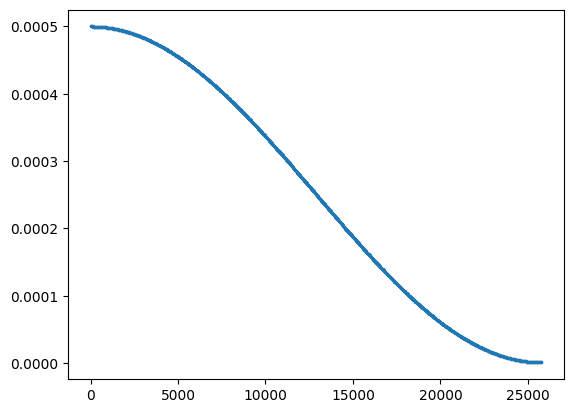


---------Training..........---------
train:66210 valid:998



Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 1/201



Lev distance: 0.010002235136343317


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: , len: 0
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: , len: 0
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: , len: 0
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: , len: 0
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: , len: 0
-----


Lev distance: 0.08549396513187305


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 9, len: 1
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: , len: 0
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: aiioc, len: 5
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: , len: 0
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 8, len: 


Lev distance: 0.2682163611980331


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 93, len: 2
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: lauchade, len: 8
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: iradashisicoeco, len: 15
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: , len: 0
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



Lev distance: 0.392545820295038


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 93, len: 2
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 4rslaurnchadne, len: 14
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphisiorostes.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: , len: 0
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.4231113097898972


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 953, len: 3
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: brslaurnchadne, len: 14
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphisiostes.com, len: 22
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: , len: 0
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.4513299061242736


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 933, len: 3
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bbrgslaurnchadne, len: 16
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: irandasphisirosteps. com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: , len: 0
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.45607957085382206


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 9339, len: 4
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 4bugslaunchadne, len: 15
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: irandasphisirosteps.com, len: 23
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: er, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.48876843987483237


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 9539, len: 4
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: brugs.laurnochad.ne, len: 19
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: irandasphysirosteps.com, len: 23
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.5049172999552973


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: brgst.launochpad.ne, len: 19
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphisiorosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.5130196691998212


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 4bugstlaunchpad.ne, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: irandasphysirosteps.com, len: 23
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.5144725078229772


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 4bugslaunchpad.ne, len: 17
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: irandasphysirosteps.com, len: 23
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.5221278497988378


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: brugslaunchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: irandasphysirosteps.com, len: 23
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.542355833705856


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bbugst.launchpad.net, len: 20
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: irandasphysirosteps.com, len: 23
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.5514640143048726


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugslaunchpad.net, len: 17
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: irandasphysirosteps.com, len: 23
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.5591193562807332


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: irandasphysirosteps.com, len: 23
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.5553196244970944


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launochppad.net, len: 20
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wirandasphysiorosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.5673893607510058


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 9533-9, len: 6
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: irandasphysirosteps.com, len: 23
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.5730330800178811


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wirandasphysirosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.5823088958426464


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wirandasphysiorosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.5888466696468485


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +9539, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wirandasphysiorosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.5864997764863656


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 9533-9, len: 6
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphisirosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.5713008493518105


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: irandasphysirosteps.com, len: 23
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.5883996423781851


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6043808672329012


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysiorosteps.com, len: 26
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6044367456414841


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.5943227536879749


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: irandasphysirosteps.com, len: 23
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6174564148413053


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 9539, len: 4
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6158918194009835


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95339, len: 6
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: irandasphysirosteps.com, len: 23
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: ec, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6241059454626732


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-339, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6185181046043808


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: e, len: 1
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6217031738936075


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.622876620473849


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6186857398301296


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95339, len: 6
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6310907465355386


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6299172999552973


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-339, len: 6
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6370697362539115


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6314818953956192


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-3-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: eirandasphysirosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6374608851139919


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  ec, len: 3
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6405341975860528


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6412047384890478


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandrasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6415958873491283


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandrasphysirosteps.com, len: 26
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6402548055431382


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: vmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6457867679928475


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandrasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6439427805096111


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysirosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6455632543585159


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandrasphysirosteps.com, len: 26
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eo, len: 3
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6496982565936522


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e o c, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.653497988377291


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysirosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6504805543138131


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eonc, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.652771569065713


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eo, len: 3
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6561801519892714


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-339, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6523804202056326


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95339, len: 6
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 0e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6526598122485472


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-339, len: 6
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bbugs.launchpad.net, len: 19
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandrasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6527156906571301


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: vmirandrasphysirosteps.com, len: 26
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6644501564595441


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: vmirandrasphysirosteps.com, len: 26
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eonc, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6625502905677246


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandrasphysidosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  ec, len: 3
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6622150201162271


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-339, len: 6
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: vmirandrasphysirosteps.com, len: 26
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eon, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.660818059901654


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandrasphysirosteps.com, len: 26
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  en, len: 3
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6649530621367904


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: wmirandasphysidosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eonc, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6642266428252124


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: vmirandrasphysidosteps.com, len: 26
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6636119803308002


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eo, len: 3
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6623826553419758


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95339, len: 5
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: vmirandasphysidosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  een, len: 4
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.667467590523022


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: vmirandrasphysidosteps.com, len: 26
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eon, len: 4
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6671881984801072


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: vmirandasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eonc, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6722172552525704


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eoc, len: 4
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.668864550737595


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.665958873491283


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysirosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6678028609745195


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95--33-9, len: 9
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandrasphysirosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.671714349575324


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  ec, len: 3
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6733907018328118


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eon, len: 4
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.673949485918641


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: vmirandasphysidosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  e, len: 2
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6738377291014752


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eon, len: 4
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6741729995529727


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eonc, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6723290120697363


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eon, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6763522574877068


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 9533-9, len: 6
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eoncc, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6757934734018776


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eon , len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6708761734465802


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 9533-9, len: 6
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eni, len: 4
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6767992847563702


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eonc, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6778609745194457


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95--33-9, len: 9
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandrasphysidosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 50 en , len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6758493518104605


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-339, len: 6
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eon , len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6852928028609745


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eon , len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6776933392936969


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eon , len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6837282074206527


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eon c, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.683448815377738


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: +95-33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eon c, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6824988824318283


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eoncc, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6804872597228431


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  enc, len: 4
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.686410371032633


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: vmirandasphysidosteps.com, len: 25
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  eon , len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.679760840411265


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  en, len: 3
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6826106392489942


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enc, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6840075994635673


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eoncc, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6841193562807332


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  enon, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6839517210549844


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  enc, len: 4
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6843987483236478


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  en, len: 3
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6804313813142602


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enc, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6832253017434063


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enc, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6874161823871257


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 en c, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6843987483236478


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eon , len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6831135449262405


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-29, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  enr, len: 4
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6836164506034869


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eon , len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6890366562360304


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eon c, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6888131426016987


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eon , len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.68635449262405


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enr, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6862986142154671


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enc, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6882543585158695


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eon c, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6892042914617792


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  en , len: 4
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6862427358068842


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 en , len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6882543585158695


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-29, len: 9
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eonr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6842869915064819


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eonr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6879749664729549


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enr, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6884778721502012


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 en , len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6910482789450156


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enrc, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6906571300849352


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eonr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6868015198927134


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eonr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.687807331247206


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enr, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6872485471613768


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enr, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6889248994188646


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 en, len: 4
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6913276709879302


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eon c, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.68864550737595


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eonrc, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6895954403218596


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enon c, len: 8
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^


Lev distance: 0.687863209655789


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eonr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6898189539561913


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6902101028162718


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6903777380420205


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eonrc, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6917746982565937


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eon , len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6879749664729549


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  enr, len: 4
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6918864550737595


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eon , len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6912159141707644


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6899865891819401


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eonr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6931716584711668


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eonr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6928363880196692


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eonr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6913276709879302


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eonr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6934510505140814


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6925569959767546


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eonr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6924452391595888


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--336-9, len: 9
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 eonrc, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6946244970943227


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 en , len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6943451050514081


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 en , len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6931157800625838


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enon c, len: 8
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6941774698256593


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enn , len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6921099687080912


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 en , len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6928922664282521


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction:  enn , len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6932834152883326


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.693730442556996


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enon , len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6926687527939205


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6929481448368351


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 en , len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6950156459544032


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enn , len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6946803755029056


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 en , len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6948480107286544


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6931716584711668


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6939539561913277


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enn , len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6952950379973178


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.694400983459991


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6970272686633885


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--336-9, len: 9
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6940657130084935


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6949038891372373


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6931716584711668


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enr, len: 5
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.695239159588735


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6955744300402324


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6954067948144836


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.693730442556996


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6961890925346446


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6953509164059007


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6935628073312472


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6957420652659813


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.694456861868574


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.694400983459991


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6938980777827447


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6941215914170764


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6946803755029056


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.694456861868574


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6949597675458203


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6940657130084935


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6938421993741618


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6947362539114886


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95-33-9, len: 7
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6940657130084935


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 ennr, len: 6
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6946803755029056


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6941774698256593


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6946244970943227


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6947921323200715


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6938421993741618


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6948480107286544


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6945686186857398


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6955744300402324


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6949597675458203


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6947362539114886


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.695127402771569


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6947362539114886


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6950156459544032


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6951832811801519


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6948480107286544


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6950156459544032


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6952950379973178


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6940098345999106


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.694400983459991


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6947362539114886


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6953509164059007


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6942892266428252


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6947921323200715


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6951832811801519


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6945686186857398


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6950156459544032


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.695127402771569


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^


Lev distance: 0.6953509164059007


Exception ignored in: <function Executor.__del__ at 0x7bfb943d15a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


----------------------------------------------------------------------------------------------------
Target    : +95-335-395^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 95--33-9, len: 8
----------------------------------------------------------------------------------------------------
Target    : bugs.launchpad.net^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: bugs.launchpad.net, len: 18
----------------------------------------------------------------------------------------------------
Target    : mirandasphysiosteps.com^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: mirandasphysidosteps.com, len: 24
----------------------------------------------------------------------------------------------------
Target    : 5 endeavor circle^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Prediction: 5 enonr, len: 7
----------------------------------------------------------------------------------------------------
Target    : +44-4560-846^^^^^^^^^^^^^^^^^^^^

(<keras.engine.functional.Functional at 0x7bfb23681a80>,
 25.078781127929688,
 <keras.callbacks.History at 0x7bfb25523f10>)

In [ ]:
do_train(cfg, train_files, valid_files, strategy=strategy, summary=True)

In [ ]:
wandb.finish()
from google.colab import runtime
runtime.unassign()

epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,███████████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁
epoch/loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_competition_metric,▁▅▆▆▇▇▇▇▇▇██████████████████████████████
epoch/epoch,200
epoch/learning_rate,0.0005
epoch/loss,16.49897
epoch/val_loss,25.07878
val_competition_metric,0.69535
